In [2]:
import os
import json
import pandas as pd
from transformers import AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from scipy.special import softmax

In [3]:
project_dir = '/Users/paulp/Library/CloudStorage/OneDrive-UniversityofEasternFinland/UEF/Thesis'
data_dir = os.path.join(project_dir, 'Data')
model_dir = os.path.join(project_dir, 'Models')

os.chdir(model_dir)
tokenizer = AutoTokenizer.from_pretrained('custom_bert_tokenizer')

os.chdir(data_dir)

#train = pd.read_csv('train.csv', index_col = 0).reset_index(drop=True)
#test = pd.read_csv('test.csv', index_col = 0).reset_index(drop=True)
full_dataset = pd.read_csv('masked_data_set.csv', index_col=0).reset_index(drop=True)

with open('target_idx.json')as file:
    target_idx = json.loads(file.read())

In [4]:
# build frequency distribution
def build_frequency_dist(dataframe, vocab):
    freq_dist = {b:{'id':vocab[b], 'freq':0} for b in vocab}
    
    for row in dataframe['Text']:
        tokens = tokenizer.tokenize(row)
        for tok in tokens:
            try:
                freq_dist[tok]['freq'] += 1
            except:
                pass
    return freq_dist

In [5]:
freq_dist = build_frequency_dist(full_dataset, tokenizer.vocab)

Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors


In [6]:
freq_dist

{'gmail': {'id': 19841, 'freq': 6},
 'invad': {'id': 16834, 'freq': 0},
 'cash': {'id': 3992, 'freq': 199},
 '##guide': {'id': 15666, 'freq': 4},
 '##unt': {'id': 5512, 'freq': 23},
 'disk': {'id': 17853, 'freq': 13},
 'broken': {'id': 4165, 'freq': 183},
 'worked': {'id': 2471, 'freq': 480},
 'joeran': {'id': 20588, 'freq': 6},
 'wearing': {'id': 3162, 'freq': 306},
 'csr': {'id': 3337, 'freq': 276},
 '##uations': {'id': 12823, 'freq': 16},
 '##eer': {'id': 21628, 'freq': 18},
 '##j': {'id': 124, 'freq': 54},
 'hateful': {'id': 19377, 'freq': 7},
 'ranged': {'id': 18620, 'freq': 7},
 'regime': {'id': 9375, 'freq': 36},
 'divers': {'id': 4392, 'freq': 18},
 'costomer': {'id': 20447, 'freq': 6},
 'gabriela': {'id': 17379, 'freq': 9},
 'prise': {'id': 22021, 'freq': 6},
 'kil': {'id': 7569, 'freq': 13},
 'loyalty': {'id': 10765, 'freq': 25},
 'speaking': {'id': 2090, 'freq': 632},
 'expressed': {'id': 7396, 'freq': 56},
 'exit': {'id': 8912, 'freq': 38},
 'blankets': {'id': 13133, 'freq'

In [7]:
freq = pd.DataFrame.from_dict(freq_dist, orient ='index')
freq = freq.sort_values(by='freq', ascending=False)
# trim out sparse tokens
freq = freq.query("`freq` >= 24")
freq['log_freq'] = freq['freq'].apply(lambda x: np.log(x))
freq = freq.reset_index()

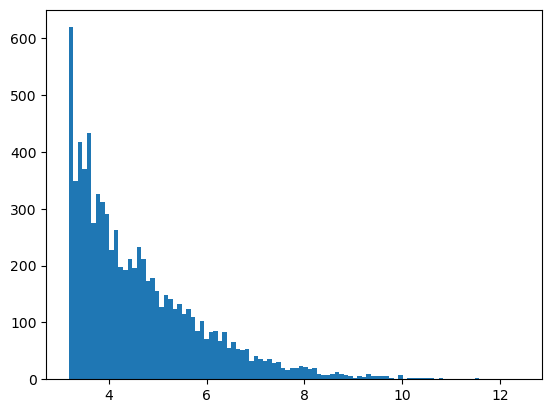

In [8]:
plt.hist(freq['log_freq'], bins = 100);

In [9]:
# set the threshold up even farther - sparse tokens are 
# also more likely to be coincidentally biased
freq = freq.query("`log_freq` >= 4.0")

In [10]:
token_idx_map = {b:a for a,b in enumerate(freq['index'])}

In [11]:
def get_doc_freq_vecs(dataframe, token_idx_map, frequency_dist, tfidf=False):
    target_matrix = np.array([target_idx[a] for a in dataframe['Target']])
    feature_matrix = np.zeros((len(dataframe),len(frequency_dist)))
    for s, row in enumerate(dataframe['Text']):
        tokens = tokenizer.tokenize(row)
        for tok in tokens:
            try:
                ind = token_idx_map[tok]
                feature_matrix[s,ind] += 1
            except:
                pass
            
    if tfidf:
        idf_smooth, feature_matrix = tf_idf(feature_matrix) 
        return idf_smooth, feature_matrix, target_matrix
    else:
        return feature_matrix, target_matrix

In [12]:
# make an identical dataframe with frequencies of arrays
def get_doc_freq_vecs(dataframe, token_idx_map, frequency_dist, tfidf=False):
    target_matrix = np.array([target_idx[a] for a in dataframe['Target']])
    feature_matrix = np.zeros((len(dataframe),len(frequency_dist)))
    
    new_df = dataframe.copy()
    new_df['Target_ID'] = np.array([target_idx[a] for a in dataframe['Target']])
    for s, row in enumerate(dataframe['Text']):
        tokens = tokenizer.tokenize(row)
        for tok in tokens:
            try:
                ind = token_idx_map[tok]
                feature_matrix[s,ind] += 1
            except:
                pass
            
    #new_df['Token_Freq'] = feature_matrix
    return feature_matrix

In [13]:
frequency_data =get_doc_freq_vecs(full_dataset, token_idx_map, freq_dist)

In [14]:
#Frequency_Data
target_inds = np.array([target_idx[a] for a in full_dataset['Target']])

In [20]:
len(frequency_data[np.where(target_inds == 1),:][0])

2892

In [42]:
k = full_dataset['k'].to_numpy()

In [41]:
new_dataset['Target'] = np.array([target_idx[a] for a in full_dataset['Target']])

In [43]:
# save these results to data_dir
token_idx = json.dumps(token_idx_map)
with open('token_idx_map.json', 'w') as file:
    file.write(token_idx)

with open('frequency_data.npy', 'wb') as file:
    np.save(file, frequency_data)

with open('target_inds.npy', 'wb') as file:
    np.save(file, target_inds)

with open('k.npy', 'wb') as file:
    np.save(file, k)

In [53]:
with open('freq_feature_matrix.npy', 'wb') as file:
    np.save(file, feature_matrix)

In [ ]:
pd.DataFrame(target_matrix).to_csv('target_matrix.csv')

In [ ]:
pd.DataFrame(feature_matrix).to_csv('feature_relative_matrix.csv')

In [ ]:
os.chdir('bayesian_linear_classifier')
with open('feature_counts_matrix.npy', 'wb') as file:
    np.save(file, feature_matrix)

In [ ]:
#os.chdir('bayesian_linear_classifier')
with open('feature_percent_matrix.npy', 'wb') as file:
    np.save(file, feature_matrix)

In [44]:
!pwd

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/paulp/Library/CloudStorage/OneDrive-UniversityofEasternFinland/UEF/Thesis/Data


In [45]:
help(tokenizer)

Help on BertTokenizerFast in module transformers.models.bert.tokenization_bert_fast object:

class BertTokenizerFast(transformers.tokenization_utils_fast.PreTrainedTokenizerFast)
 |  BertTokenizerFast(vocab_file=None, tokenizer_file=None, do_lower_case=True, unk_token='[UNK]', sep_token='[SEP]', pad_token='[PAD]', cls_token='[CLS]', mask_token='[MASK]', tokenize_chinese_chars=True, strip_accents=None, **kwargs)
 |  
 |  Construct a "fast" BERT tokenizer (backed by HuggingFace's *tokenizers* library). Based on WordPiece.
 |  
 |  This tokenizer inherits from [`PreTrainedTokenizerFast`] which contains most of the main methods. Users should
 |  refer to this superclass for more information regarding those methods.
 |  
 |  Args:
 |      vocab_file (`str`):
 |          File containing the vocabulary.
 |      do_lower_case (`bool`, *optional*, defaults to `True`):
 |          Whether or not to lowercase the input when tokenizing.
 |      unk_token (`str`, *optional*, defaults to `"[UNK]"`):

In [49]:
tokenizer

PreTrainedTokenizerFast(name_or_path='custom_bert_tokenizer', vocab_size=22500, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]', 'additional_special_tokens': ['<?>', '<*>', '<R>', '<MISC>', '<ORG>', '<LOC>', '<PER>']})